# Visualization of filters by reconstruction
In this part of the lab we consider reconstruction-based filter visualization.

The content is inspired by [this blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html), which unfortunately is deprecated.

We will this this one instead:

- Blog post: https://keras.io/examples/vision/visualizing_what_convnets_learn/

- Source: https://github.com/keras-team/keras-io/blob/master/examples/vision/visualizing_what_convnets_learn.py

- Colab version: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb


**Before we start - remember to set runtime to GPU**

## Set up network
We will be using VGG16 like in Lab 10, part 1.

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 224
img_height = 224

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "block3_conv3"

In [39]:
# Build a VGG16 model loaded with pre-trained ImageNet weights
model = keras.applications.VGG16(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

## Set up the gradient ascent process
The "loss" we will maximize is simply the mean of the activation of a specific filter in our target layer. To avoid border effects, we exclude border pixels.

In [40]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

Our gradient ascent function simply computes the gradients of the loss above with respect to the input image, and update the image so as to move it towards a state that will activate the target filter more strongly.

In [41]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

Some background reading in case you are interested: 
- https://www.tensorflow.org/api_docs/python/tf/GradientTape
- https://www.tensorflow.org/guide/autodiff

## Set up the end-to-end filter visualization loop
Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural).
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it, center-cropping it, and restricting it to the [0, 255] range.


In [42]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # VGG16 expects inputs in the range [-128, +128].
    # Here we scale our random inputs to [-32, +32]
    return (img - 0.5) * 64


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 200.0 # learning must be high for this wo converge fast enough
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Let's try it out with filter 0 in the target layer:

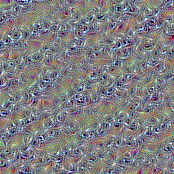

In [43]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

display(Image("0.png"))

## Visualize the first 16 filters in the target layer
Now, let's make a 4x4 grid of the first 16 filters in the target layer to get of feel for the range of different visual patterns that the model has learned.

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15


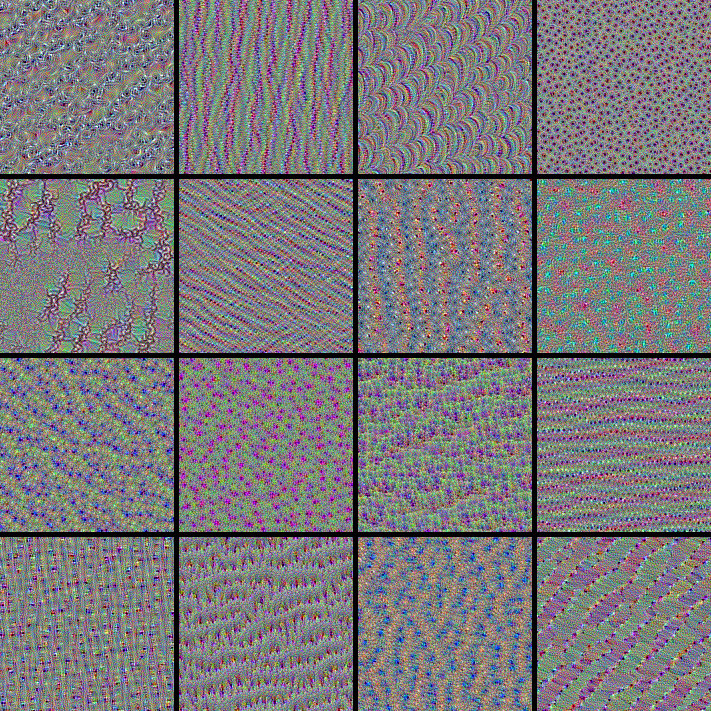

In [23]:
# Compute image inputs that maximize per-filter activations
# for the first 16 filters of our target layer
all_imgs = []
for filter_index in range(16):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 4 x 4 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 4
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

## Questions
1. The computational graph is changed in order to derive the filter response image. How is the graph modified?
2. How is the loss calculated? What is being maximized/minimized?
3. Try visualizing other filters from another layer. **Note:** You may need to adjust `iterations` and `learning_rate`

In [37]:
# Print names of all conv layers
for i, layer in enumerate(model.layers):
  
  # check for convolutional layer
  layer_type = layer.__class__.__name__
  
  if 'Conv' not in layer_type:
    continue
  
  # get filter weights
  layer_name = layer.name
  input_shape = layer.input_shape
  output_shape = layer.output.shape
  filter_shape = layer.get_weights()[0].shape
  
  print(f"Layer {i} has name {layer_name}, input shape {input_shape}, filter shape {filter_shape}, and output shape {output_shape}")

Layer 1 has name block1_conv1, input shape (None, None, None, 3), filter shape (3, 3, 3, 64), and output shape (None, None, None, 64)
Layer 2 has name block1_conv2, input shape (None, None, None, 64), filter shape (3, 3, 64, 64), and output shape (None, None, None, 64)
Layer 4 has name block2_conv1, input shape (None, None, None, 64), filter shape (3, 3, 64, 128), and output shape (None, None, None, 128)
Layer 5 has name block2_conv2, input shape (None, None, None, 128), filter shape (3, 3, 128, 128), and output shape (None, None, None, 128)
Layer 7 has name block3_conv1, input shape (None, None, None, 128), filter shape (3, 3, 128, 256), and output shape (None, None, None, 256)
Layer 8 has name block3_conv2, input shape (None, None, None, 256), filter shape (3, 3, 256, 256), and output shape (None, None, None, 256)
Layer 9 has name block3_conv3, input shape (None, None, None, 256), filter shape (3, 3, 256, 256), and output shape (None, None, None, 256)
Layer 11 has name block4_conv1, 

# Grad-CAM
If time permits, you may also want to try out Grad-CAM.

The code is based on [this tutorial](https://keras.io/examples/vision/grad_cam/).

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

You can change these to another model.

To get the values for last_conv_layer_name use model.summary() to see the names of all layers in the model.

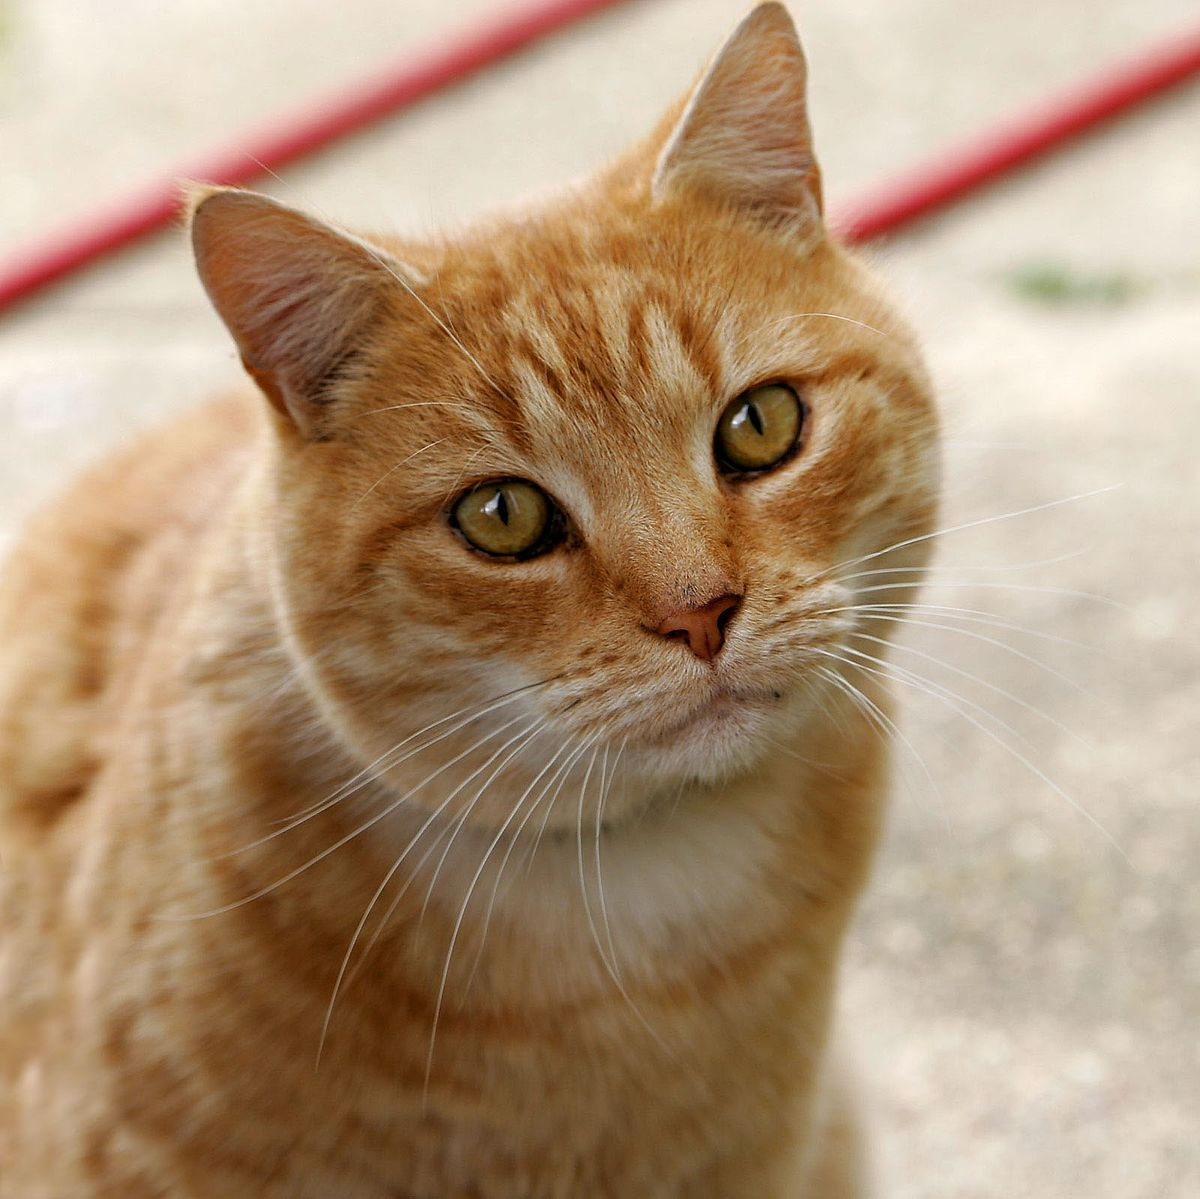

In [46]:
model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = keras.utils.get_file(
    "cat.jpg", "https://raw.githubusercontent.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2021/main/data/cat.jpg"
)

display(Image(img_path))

## The Grad-CAM algorithm

In [47]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Let's test-drive it

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02123159', 'tiger_cat', 11.730517)]


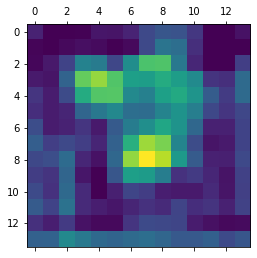

In [48]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Create a superimposed visualization

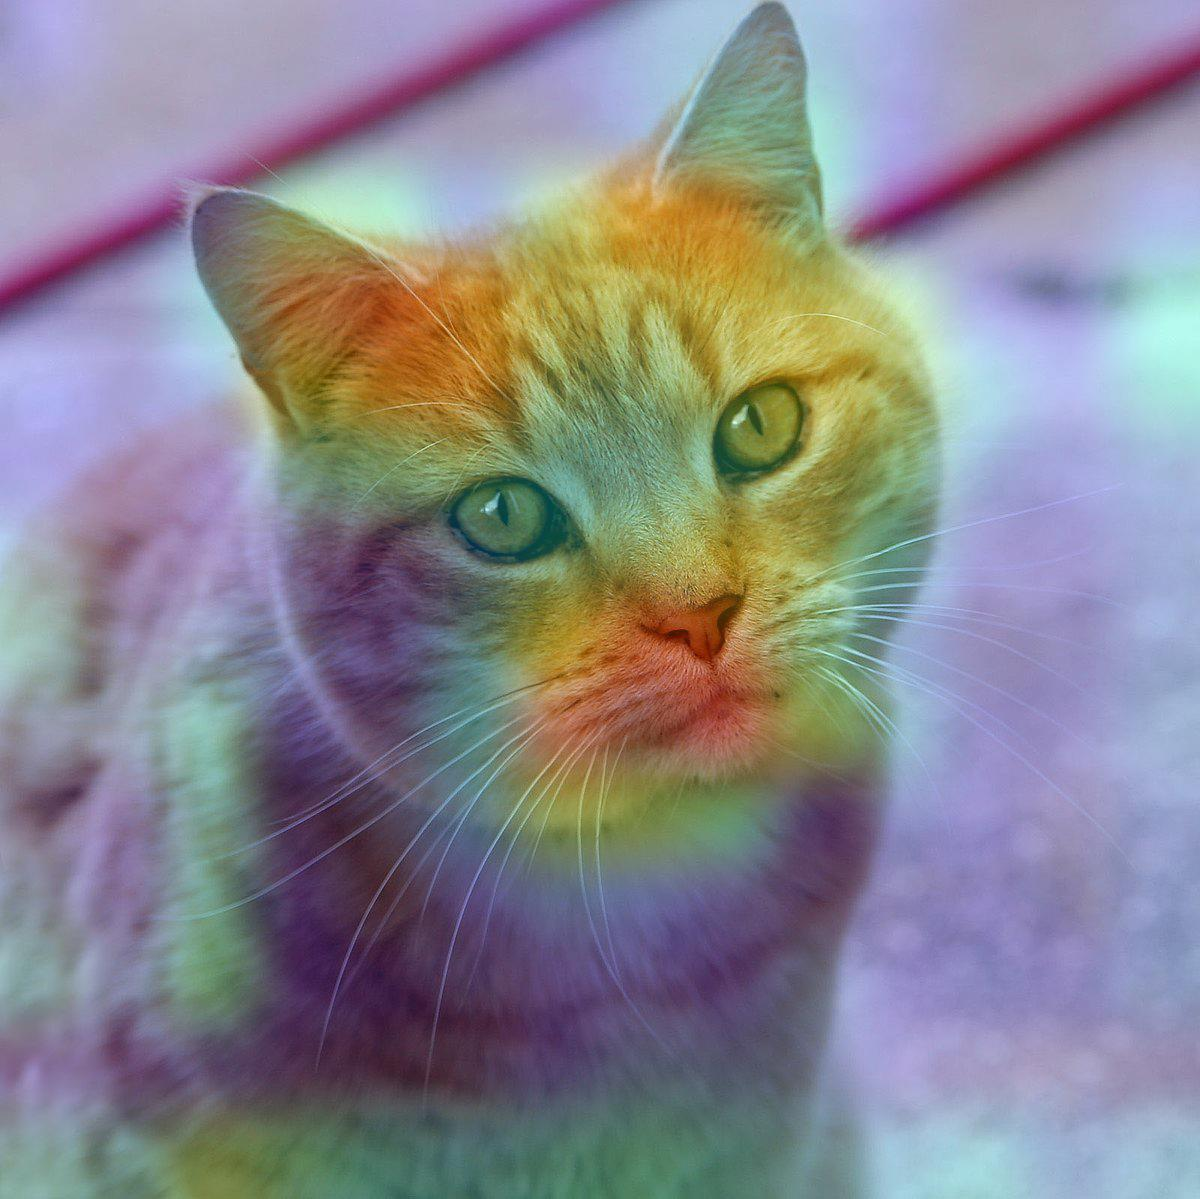

In [49]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Let's try another image
We will see how the grad cam explains the model's outputs for a multi-label image. Let's try an image with a cat and a dog together, and see how the grad cam behaves.

81920/72452 [=================================] - 0s 0us/step


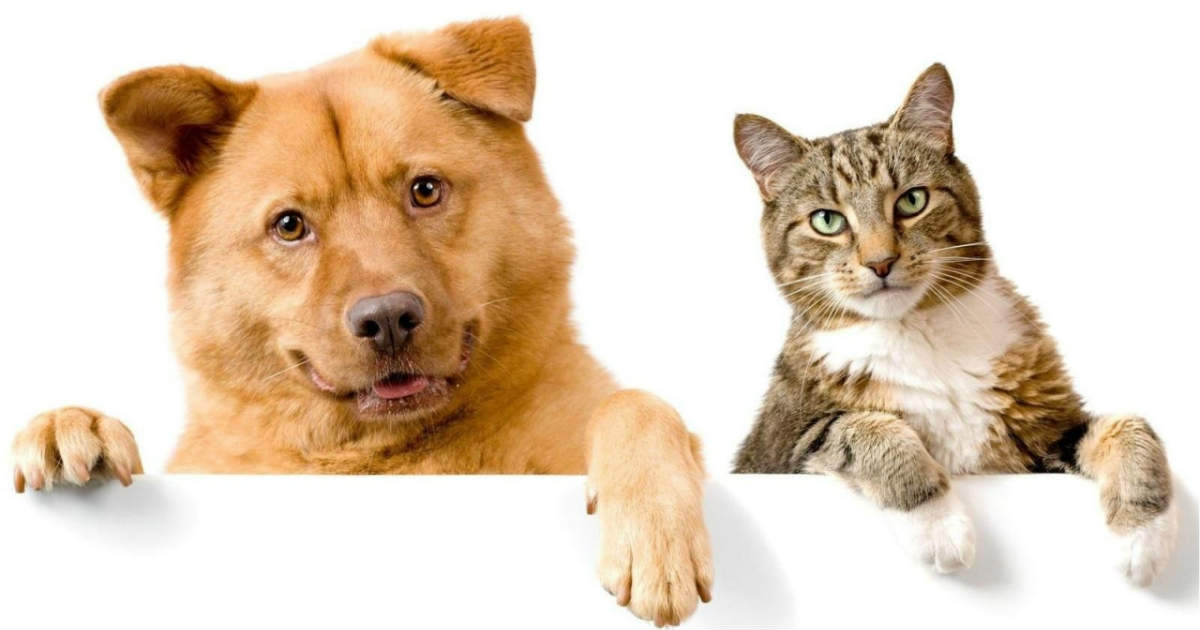

Predicted: [('n02106030', 'collie', 8.145559), ('n02110806', 'basenji', 7.812911)]


In [50]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

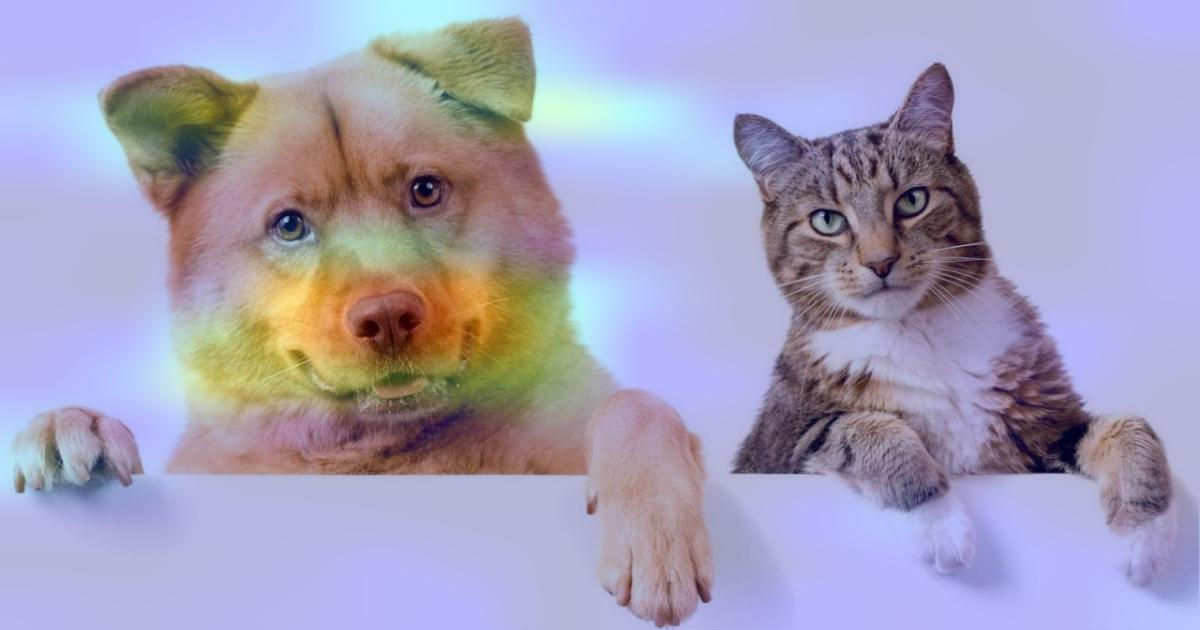

In [51]:
# dog heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)
save_and_display_gradcam(img_path, heatmap)

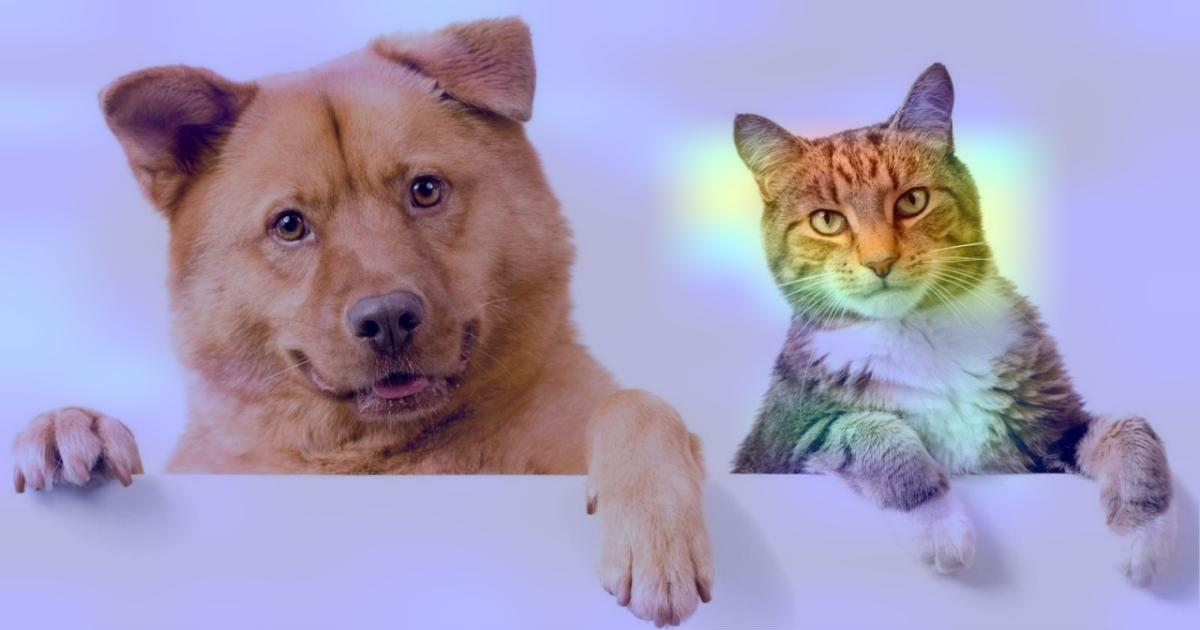

In [52]:
# Cat heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)
save_and_display_gradcam(img_path, heatmap)

## Question
1. The computational graph is changed in order to compute the heatmaps. How is the graph modified?